<a href="https://colab.research.google.com/github/isakdiaz/treenet-colab/blob/main/treenet_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Mount Google Drive

In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Download Dataset

In [13]:
# Dataset URL
#!gdown https://drive.google.com/uc?id=1N-9k7Aa-GRAoiuKgM7ERPn-UkKdgcfIa
!gdown https://drive.google.com/uc?id=1ggpRqJiyKFWHj1lhbjGjILwm-WRgGaRt

Downloading...
From: https://drive.google.com/uc?id=1ggpRqJiyKFWHj1lhbjGjILwm-WRgGaRt
To: /content/barknet.zip
100% 390M/390M [00:03<00:00, 128MB/s]


# Import Tensorflow and other things

In [14]:
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import pprint
import json
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score


import tensorflow_datasets as tfds

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing import image

print("Tensorflow version is " + tf.__version__)

Tensorflow version is 2.6.0


In [15]:
!ls

1ggpRqJiyKFWHj1lhbjGjILwm-WRgGaRt  barknet.zip	drive  sample_data


In [16]:
# Place the plantnet zipped file in a folder called plantnet on your Google Drive directory
# Unzips files from google drive to google colab
!unzip /content/barknet.zip

Archive:  /content/barknet.zip
   creating: barknet/
   creating: barknet/phoenix-sylvestris/
   creating: barknet/sabal-palmetto/
  inflating: barknet/.DS_Store       
  inflating: __MACOSX/barknet/._.DS_Store  
   creating: barknet/pinus-clausa/
   creating: barknet/pseudotsuga-menziesii/
   creating: barknet/sequoia-sempervirens/
   creating: barknet/umbellularia-californica/
   creating: barknet/nothing-found/
   creating: barknet/magnolia-grandiflora/
   creating: barknet/quercus-virginiana/
   creating: barknet/quercus-agrifolia/
  inflating: barknet/phoenix-sylvestris/C3A5082C-EB81-4852-8746-E4BCEE83DD05.png  
  inflating: barknet/phoenix-sylvestris/4C537023-2719-45D9-8B86-70C2AD3BA24B.png  
  inflating: barknet/phoenix-sylvestris/70024A03-35C3-40F6-95FB-0F46A5CC600A.png  
  inflating: barknet/phoenix-sylvestris/27BBED45-DE19-472E-BA32-DA87E8A448A0.png  
  inflating: barknet/phoenix-sylvestris/4F8D0703-2725-4700-8407-8739CE39ADC9.png  
  inflating: barknet/phoenix-sylvestris/DBB

In [18]:
# Check file unzipped properly
!du -hs barknet/

373M	barknet/


In [20]:
# Get labels from folder names
DATASET_PATH = '/content/barknet'
children= [os.path.join(DATASET_PATH, child) for child in os.listdir(DATASET_PATH)]
files = filter(os.path.isdir, children)
labels = sorted([file.split("/")[-1] for file in files])
num_classes = len(labels)

print(f"Dataset contains {num_classes} classes.")
labels

Dataset contains 10 classes.


['magnolia-grandiflora',
 'nothing-found',
 'phoenix-sylvestris',
 'pinus-clausa',
 'pseudotsuga-menziesii',
 'quercus-agrifolia',
 'quercus-virginiana',
 'sabal-palmetto',
 'sequoia-sempervirens',
 'umbellularia-californica']

# Create Datasets for training process
## Pick a Method






In [21]:
SEED = 123
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
VALIDATION_SPLIT = 0.1

In [22]:

# def process_dataset(image, label):
#   # image = tf.image.resize(image, (224, 224))
#   # image = preprocess_input(image)
#   image = image/127.0 - 1 #normalize around -1 to +1

#   return(image, label)

# By default flow_from_directory shuffles data
train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=45,
        width_shift_range=0.2,
        height_shift_range=0.2,
        brightness_range=(0.5,1.0),
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode="reflect",
        validation_split=VALIDATION_SPLIT
        )
train_generator = train_datagen.flow_from_directory(
        DATASET_PATH,
        target_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical')

# validation_datagen = ImageDataGenerator(rescale=1./255, validation_split=VALIDATION_SPLIT)

validation_generator = train_datagen.flow_from_directory(
        DATASET_PATH,    # Same folder as training data
        target_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical')


Found 500 images belonging to 10 classes.
Found 500 images belonging to 10 classes.


## Plot Images


Image Sizes: (32, 224, 224, 3)


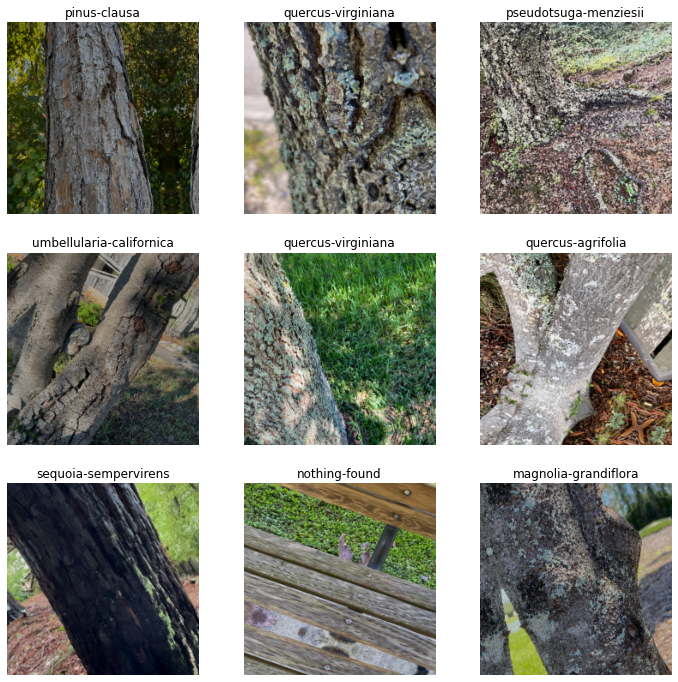

In [24]:
import matplotlib.pyplot as plt

x,y = train_generator.next()
print("Image Sizes: " + str(x.shape))

plt.figure(figsize=(12, 12))

for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    image = x[i] 
    plt.imshow(image)
    plt.title(labels[np.argmax(y[i])])
    plt.axis("off")

# Model Creation
## Create Model Base from MobileNetV2 without top layers


In [25]:
# Mobilenet was originally trained with -1 to +1 values, Normalizer sets images within this range so pretrained weights work properly

base_model = tf.keras.applications.MobileNetV2(
    input_shape = (224,224,3),
    alpha=1.0,
    include_top=False,
    weights="imagenet",
    pooling=None,
    classifier_activation="softmax",
)

9420800/9406464 [==============================] - 0s 0us/step


## Add Final 3 layers to base model
These will help us classify our own specific data even if we freeze the base model. Also the last layer has 1081 nodes which will match the size of our classification labels.



In [26]:
# Let's add final trainable layers to learn our specific data
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation="relu")(x)
predictions = Dense(num_classes, activation="softmax")(x)

## Finish creating complete model



In [27]:
model = Model(inputs = base_model.input, outputs = predictions)

## Freeze the model middle layers
Note: Changing this parameter must be done after the model is created, or else it won't train properly.



In [28]:
# NOTE: Freezing layers requires that you load weights from a previous model, or else all middle layers will
# have random initialization that does not learn
FREEZE_LAYERS = True

base_model.trainable = not FREEZE_LAYERS
print("Base Model is {}trainable.".format("" if base_model.trainable else "NOT "))

Base Model is NOT trainable.


# Set Up Optimizer


In [29]:
LEARNING_RATE = 0.01
opt = 'rmsprop'

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics= ["accuracy", 'top_k_categorical_accuracy'])

#Plot the Model
Warning: Usually very long

In [ ]:
PLOT_MODEL = False

if PLOT_MODEL:
  tf.keras.utils.plot_model(
      model, to_file='model.png', show_shapes=True, show_dtype=True,
      show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96
  )

# Load Previous Model

In [32]:
LOAD_PREVIOUS_MODEL = False
from datetime import datetime 

# Date Time
current_time = datetime.now().strftime('%Y%m%d-%H:%M:%S')
current_date = datetime.now().strftime('%Y%m%d')
GDRIVE_DIR = "/content/drive/MyDrive/saved_models/treenet/" # Save Path for models

if(LOAD_PREVIOUS_MODEL):
  filepath = "/content/drive/MyDrive/saved_models/treenet/treenet_20210929.h5"
  # Try loading model at filepath to continue training
  # If no file exists then it creates a new one
  try:
    model = keras.models.load_model(filepath)
    print("Continuing training from checkpoint at {}".format(filepath))
  except:
    print("No keras model found at {}, will start training from scratch.".format(filepath))
    # filepath = "{0}plantNet_{1}_{2}_{3}_{4}.h5".format(GDRIVE_DIR, BATCH_SIZE, OPTIMIZER, LEARNING_RATE, current_date)
    filepath = "{0}treenet{1}_{2}.h5".format(GDRIVE_DIR, BATCH_SIZE, current_date)
    print("New model filename is {}".format(filepath))
else:
  filepath = "{0}treenet{1}_{2}.h5".format(GDRIVE_DIR, BATCH_SIZE, current_date)
  print("New model filename is {}".format(filepath))


New model filename is /content/drive/MyDrive/saved_models/treenet/treenet32_20211103.h5


# Set Up Callbacks

In [35]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Save model only when validation accuracy increases
# checkpoint = ModelCheckpoint(filepath, monitor="val_acc", verbose=1, save_best_only=True, mode="max")
checkpoint = ModelCheckpoint(filepath, save_best_only=False, save_weights_only=False)

# Tensorboard callback
logdir = GDRIVE_DIR + "logs/" + current_time
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir, histogram_freq=1, write_images=True, embeddings_freq=1)

# Stop training model if validation loss does not improve for 3 epochs
earlyStopping = EarlyStopping(monitor="val_loss", patience=5, verbose=1)

callbacks_list = [checkpoint, earlyStopping, tensorboard_callback]

# Train Model

In [38]:
epochs = 15
steps_per_epoch = None
history = model.fit(train_generator, validation_data=validation_generator, epochs=epochs, callbacks=callbacks_list, steps_per_epoch=steps_per_epoch)



/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 1/15
16/16 [==============================] - 23s 1s/step - loss: 0.1964 - accuracy: 0.9300 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.1604 - val_accuracy: 0.9340 - val_top_k_categorical_accuracy: 1.0000
Epoch 2/15
16/16 [==============================] - 22s 1s/step - loss: 0.2048 - accuracy: 0.9340 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.1346 - val_accuracy: 0.9660 - val_top_k_categorical_accuracy: 0.9980
Epoch 3/15
16/16 [==============================] - 22s 1s/step - loss: 0.0764 - accuracy: 0.9720 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.1999 - val_accuracy: 0.9340 - val_top_k_categorical_accuracy: 1.0000
Epoch 4/15
16/16 [==============================] - 22s 1s/step - loss: 0.1281 - accuracy: 0.9440 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.0543 - val_accuracy: 0.9840 - val_top_k_categorical_accuracy: 1.0000
Epoch 5/15
16/16 [==============================] - 22s 1s/step - loss: 0.0855 - accuracy: 0.9780 - top_k_categorical_accuracy: 

In [40]:
!ls

1ggpRqJiyKFWHj1lhbjGjILwm-WRgGaRt  barknet.zip	__MACOSX
barknet				   drive	sample_data
